## Interactive Spectral Energy distribution

The goal of this tool is to show you how physical parameters impact the observed multi-wavelength flux.<br/>
The module used here is naima (http://naima.readthedocs.io/en/latest/) a package for computation of non-thermal radiation from relativistic particle populations and Markov Chain Monte Carlo fitting.  <br/>

To install naima:

conda config --add channels astropy --add channels sherpa #to add astropy affiliated packages to conda manager <br/>
conda install naima



In [239]:
%matplotlib inline

from naima import models
import naima
from astropy import units as u
from astropy import table
from astropy.io import ascii

from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from ipywidgets.widgets.interaction import interact

def plotSED_data(SEDfile,label='data',color='blue'):
    print('Reading file =', SEDfile)
    SED = table.Table.read( SEDfile, hdu=1 )        
    plt.errorbar(E[index],E2flux[index],yerr=arrowfraction*E2flux[index],uplims=True,fmt="none",ecolor=color)

def plotSED_sync_ic( distance= 1 *u.kpc, We=1e47 *u.erg, Eemin=1*u.MeV,e_break = 1 *u.GeV,
                    e_cut = 100*u.TeV,B=10 *u.uG,field="CMB", rho=1*u.cm**-3,index1=2, index2=3,N=200):
    """
    Distance needs to be in kpc
    """
    Eunits = u.eV
    Elow = np.logspace(-7,10, N) * Eunits # photon energies
    Ehigh = np.logspace(0,15, N) * Eunits # photon energies

    electrondist = models.ExponentialCutoffBrokenPowerLaw(
        amplitude=u.Quantity(1e36,"1/eV"), e_0= 1*Eunits,alpha_1=index1, alpha_2=index2,e_break=e_break, e_cutoff=e_cut, beta=2)

    ic = models.InverseCompton( electrondist, seed_photon_fields=field, Eemin=Eemin )
    syn = models.Synchrotron(electrondist, B=B,Eemin=Eemin)
    brem = models.Bremsstrahlung(electrondist,n0=rho,Eemin=Eemin)
    
    ic.set_We(We, Eemin=Eemin, Eemax=100 *u.TeV)
    syn.set_We(We, Eemin=Eemin, Eemax=100 *u.TeV)
    brem.set_We(We, Eemin=Eemin, Eemax=100 *u.TeV)
    plt.loglog(Elow, syn.sed(Elow,distance=dist ),'-', alpha=0.8,label='Synchrotron')
    plt.loglog(Ehigh, ic.sed(Ehigh,distance=dist ),'-', alpha=0.8,label='Inverse Compton')
    plt.loglog(Ehigh, brem.sed(Ehigh,distance=dist ),'-', alpha=0.8,label='Bremsstrahlung')

    
#    for f in field:
#        ic = models.InverseCompton( electrondist, seed_photon_fields=[f],Eemin=Eemin )
#        ic.set_We(We, Eemin=Eemin, Eemax=100 *u.TeV)
#        plt.loglog(Ehigh, ic.sed(Ehigh,distance=dist ),'-', alpha=0.8,label=f'IC {f[0]}')
        

def plotSED_pi0( distance = 1*u.kpc, rho=1* u.cm**-3, B=10 *u.uG,
                Wp=1e50 *u.erg, e_cut = 100*u.TeV,  index=2,N=200):
    """
    Distance needs to be in kpc and density in cm-3
    """
    
    Eunits = u.eV
    E = np.logspace(-8,14.5, N) * Eunits # photon energies
    partdist = models.ExponentialCutoffPowerLaw(
        amplitude=u.Quantity(1e36,"1/eV"), e_0= 1*Eunits, alpha=index, e_cutoff=e_cut)
    
    pi0 = models.PionDecay(partdist, nh = rho)
    psynch = models.ProtonSynchrotron(partdist, B=B)
    
    pi0.set_Wp(Wp, Epmin=1 *u.GeV, Epmax=100 *u.TeV)
    psynch.set_Wp(Wp, Epmin=1 * u.GeV, Epmax=100 *u.TeV)
    
    plt.loglog(E, pi0.sed(E,distance=distance ),'-', alpha=0.8,label='$\pi^{\circ}$ decay')
#    plt.loglog(E, psynch.sed(E,distance=distance ),'-', alpha=0.8,label='proton Synch')

    


In [242]:

dist = 1 * u.kpc
rho = 1.0 * u.cm**-3
We = 1e47 *u.erg
Wp = 1e50 *u.erg
Ecut_p = 100 *u.TeV
Eemin = 1 *u.MeV
Ecut_e = 100 *u.TeV
tel_dict={"Radio":[4e-7,4e-3],"PHEMTO":[1e3,600e3],
          "Fermi-LAT":[1e8,5e11],"Cherenkov":[1e11,100e12]}


In [218]:
def get_data_rxj(reg):
    ## Read data

    mydir='/Users/facero/Documents/Work/RXJ1713/SED/'
    # We only consider every fifth X-ray spectral point to speed-up calculations for this example
    # DO NOT do this for a final analysis!
    radio = ascii.read(mydir+'data2/Radio_RXJ_%s.ecsv'%(reg))
    soft_xray = ascii.read(mydir+'data2/Suzaku_RXJ_%s.ecsv'%(reg))#[::2]
    he = ascii.read(mydir+'data2/Fermi_RXJ1713_hessdiv_%s.ecsv'%(reg))
    vhe = ascii.read(mydir+'data2/HESS_RXJ1713_real_%s.ecsv'%(reg)) #naima handles flux to sed conversion
#    vhe = ascii.read('data2/HESS_RXJ1713_hessdiv_%s.ecsv'%(reg)) #naima handles flux to sed conversion


    return [radio,soft_xray,he, vhe]

def get_data_CasA_xray(reg):
    
    mydir='/Users/facero/Documents/Work/Xrays/wavelet-denoise/data/CasA/4638/'
    soft_xray = ascii.read(mydir+'CasA_%s_XrayFlux_diff.ecsv'%(reg))#[::2]

    return [soft_xray]

def get_data_CasA_radio():
    
    t=ascii.read(mydir+'CasA_radio_Arias2018.ecsv')

    t['energy']=t['frequency'].to('eV',equivalencies=u.spectral())
    t['flux']=(t['fluxJy'].quantity*t['frequency'].quantity).to('erg cm-2 s-1')
    t['flux_error']=(t['fluxJy_error'].quantity*t['frequency'].quantity).to('erg cm-2 s-1')

    return [t]

In [240]:
def plotSED(rho=rho,Ecut_p=Ecut_p,Eemin=Eemin,Ecut_e=Ecut_e,Ebreak=1,index1=2,index2=3,B=10,We=47,save=False):
    """
    Plot SED from an electron+proton population with Powerlaw + Exp cutoff distribution.
    Parameters:
    Index     :   Slope of the particle population
    Ecut_e/p  : Cutoff energy in TeV
    rho       : for the Pi0 decay, density of medium colliding with accelerated protons in cm-3
    B         : Magnetic field (microGauss) for synchrotron emission
    
    Notes:
    For the IC mechanism, only the CMB is assumed but naima supports other radiation field.
    """
    
    fig = plt.figure(figsize=(12,6))
    
    FIR_temp = 26 *u.K
    Uph = 1 *u.eV/u.cm**3
    plotSED_sync_ic(distance=dist,We=(10**We)*u.erg, index1=index1,index2=index2,field = ['CMB', ['FIR', FIR_temp, Uph]],
                    Eemin=Eemin*u.MeV,e_cut=Ecut_e*u.TeV,e_break=Ebreak*u.TeV, B=B*u.uG,rho=rho*u.cm**-3)
    plotSED_pi0(distance=dist,rho=rho*u.cm**-3,Wp=1e50*u.erg, e_cut=Ecut_p*u.TeV, B=B*u.uG,  index=index1)
#    plotSED_data()

#    data=get_data_rxj('fullSNR')
#    data=get_data_casA('SE_filament')
    datax=get_data_CasA_xray('allSNR')
    naima.plot_data(datax,figure=fig)
    datar=get_data_CasA_radio()
    naima.plot_data(datar,figure=fig)

    
    
    ymax=1e-8
    plt.ylim(3e-16,ymax)
    plt.xlim(3e-7,1e15)
    size=14
    plt.ylabel(r'$E^2$ d$N$/d$E$ (erg cm$^{-2}$ s$^{-1}$)',fontsize=size)
    plt.xlabel(r'$E$ (eV)',fontsize=size)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.e') )
    for tel in tel_dict:
        ax.axvspan(tel_dict[tel][0],tel_dict[tel][1],alpha=0.2,color='grey')
        plt.text(tel_dict[tel][0],ymax*1.13,tel, fontsize=size)

    x1, y1 = [10e3, 50e3, 100e3, 600e3], [8e-16, 1e-14, 5e-14, 1e-12]
    ax.plot(x1, y1,ls='--',color='black',label='PHEMTO sensitivity')
        
    plt.legend(numpoints=1, loc='lower left')
    if save :
        outfile=f'CasA_fullSNR_B{B}_rho{rho}.pdf'
        plt.savefig(outfile,dpi=100)
        print('File saved to : %s'%(outfile))
    plt.show()


interact(plotSED,Ecut_p=(1e1,1e2,1e1),Eemin=(1,100,2.5),Ecut_e=(1e1,50,2.5),index1=(1.75,2.5,0.1),index2=(2,3.5,0.1),
         rho=(0.1,30,1), B=(10,100,5),We=(46.5,49.5,0.1),save=False )

interactive(children=(FloatSlider(value=14.1, description='rho', max=30.0, min=0.1, step=1.0), FloatSlider(val…

<function __main__.plotSED(rho=<Quantity 1. 1 / cm3>, Ecut_p=<Quantity 100. TeV>, Eemin=<Quantity 1. MeV>, Ecut_e=<Quantity 100. TeV>, Ebreak=1, index1=2, index2=3, B=10, We=47, save=False)>

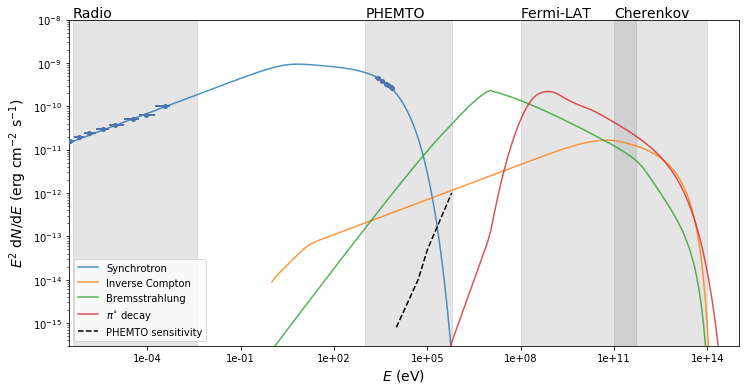

In [247]:
plotSED(rho=10,Ecut_p=70,Eemin=11,Ecut_e=50,Ebreak=1,index1=2.46,index2=3.1,B=50,We=49.2,save=False)

In [11]:
f1, f2=100 *u.MHz, 100*u.GHz
print( f1.to('eV',equivalencies=u.spectral()) )
print( f2.to('eV',equivalencies=u.spectral()) )

4.135667662340164e-07 eV
0.00041356676623401637 eV


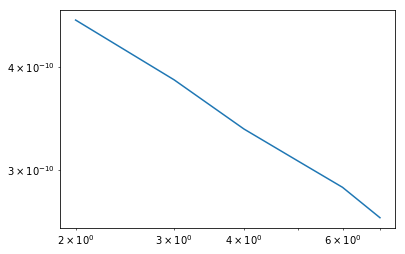

In [50]:
# Synch
E1=np.array([2, 3, 4, 5, 6, 7])
E2=np.array([3, 4, 5, 6, 7, 8])
E_center=(E2+E1)/2 *1e3

flux_int=np.array([1.85, 1.11, 0.75, 0.56, 0.44, 0.35])*1e-10
flux_diff=flux_int/np.log(E2/E1)

plt.loglog(E1,flux_diff)




In [51]:
np.savetxt('CasA_allSNR_XrayFlux_diff.dat',np.array([E_center,flux_diff]).T,header='E_center (eV)  Flux_diff (erg cm-2 s-1)',fmt='%.2e')

In [252]:
d=1e16 *u.cm

theta=(d.to('pc').value/17.5)*u.deg
theta.to('arcsec')



<Quantity 0.6666746 arcsec>